This is the Project that I've been working on while taking this [Course](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/results'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
!pip install tensorflow-text
import tensorflow_text as text

     |████████████████████████████████| 4.9 MB 30.7 MB/s 
     |████████████████████████████████| 462 kB 64.3 MB/s 


In [ ]:
data_dir='./results/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['./drive/MyDrive/results/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 './drive/MyDrive/results/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 './drive/MyDrive/results/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

<h3>Preprocessing the Data

In [ ]:
# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

In [ ]:
# Read the Lines in the Training Set
train_data_lines=get_lines(data_dir+"train.txt")
# train_data_lines[:20]

 <h4>
 Pre-processing the Data <br>
 List of dictionaries <br>
 Each line needs to be converted into a dictionary <br>
 Dictionary items are ordered, changeable, and does not allow duplicates.<br>
 Objectives, Methods, Results, Conclusins will all be Values to the 'TARGET' KEY<br>
 And the Text corresponding to them will be Values to the Key 'TEXT'<br>
 So each abstract would have about roughly 10-12 dicts for each statement<br>

In [ ]:
# Preprocessing Functions
# Returns a list of dictionaries of abstract's lines
# Dict Format --> {'TARGET':'Background/Results/Objetive/Concludion','Text':'The actual statement'}
def preprocess_data(filename):
    input_lines=get_lines(filename)
    #This will be used to separte the abstracts from  one another using String mets
    abstract_lines=""
    # Empty list of abstracts
    abstract_samples=[]
    for line in input_lines:
        # Check for a new abstract
        if line.startswith("###"):
            abstract_id=line
            # And since we are in a new abstract we will Reset the abstract_lines
            abstract_lines=""
        # Check for a new line \n escape seq
        elif line.isspace():
            # Split the Lines of the abstract and will return a list of one abstract
            abstract_line_split=abstract_lines.splitlines()
            # Now we have to iterate through this singular abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                #  Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object.
                # Create a empty Dict per line
                line_data={}
                # Split on the tab \t esc seq
                target_text_split=abstract_line.split("\t")
                # Get the Label of the sentence as the Label
                line_data["target"]=target_text_split[0]
                # Get the Text of the Lien as the Text Key
                line_data["text"]=target_text_split[1].lower()
                # Also adding the Line Nnumber as it will also aid the model
                line_data["line_number"]=abstract_line_number
                # Number of Lines in that particular abstract
                line_data["total_lines"]=len(abstract_line_split)-1
                # Now we have to append them to the absract_samples list
                abstract_samples.append(line_data)
        # So if both the cases are not there then the line is a labelled sentence
        else:
            abstract_lines+=line
    return abstract_samples
                
            
            

In [ ]:
%%time
# Get the data and preprocess it
train_samples=preprocess_data(data_dir+"train.txt")
val_samples=preprocess_data(data_dir+"dev.txt")
test_samples=preprocess_data(data_dir+"test.txt")

CPU times: user 451 ms, sys: 87.9 ms, total: 539 ms
Wall time: 3.21 s


In [ ]:
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [ ]:
# Visualizing the Data
train_samples[:2]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11}]

In [ ]:
# Now we have to turn this data into a df
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)

In [ ]:
train_df.head(11)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Checking the Spread of Data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

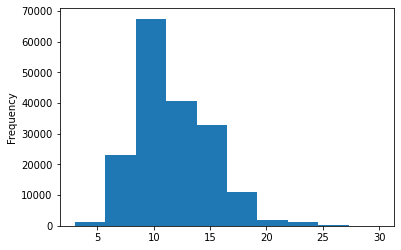

In [ ]:
# Checking the Length of Lines
train_df.total_lines.plot.hist()

In [ ]:
# Get the list of just the text Columns
train_sentences=train_df["text"].tolist()
test_sentences=test_df["text"].tolist()
val_sentences=val_df["text"].tolist()

In [ ]:
len(train_sentences),len(test_sentences),len(val_sentences)

(180040, 30135, 30212)

In [ ]:
# Turning the target Labels into Numeric Data
# We have 5 main labels -> Backgroun, Objective,Methods, Results, Conclusion
# We'll encode them both 1HEC and Simple Nuemrical
from sklearn.preprocessing import OneHotEncoder
# Tensorflow is incompaible with sparse matrices
one_hot_encoder=OneHotEncoder(sparse=False)
# You should reshape your X to be a 2D array not 1D array. Fitting a model requires requires a 2D array. i.e (n_samples, n_features)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot,val_labels_one_hot,test_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [ ]:
# Label Encoding also for Baseline Model
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train_labels_encoded=le.fit_transform(train_df["target"])
test_labels_encoded=le.fit_transform(test_df["target"])
val_labels_encoded=le.fit_transform(val_df["target"])
train_labels_encoded, test_labels_encoded,val_labels_encoded

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]),
 array([0, 0, 3, ..., 4, 1, 1]))

In [ ]:
# Retieving classes 
num_classes=len(le.classes_)
class_names=le.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

<h3> Conv 1D Model </h3>

In [ ]:
# Vectorize the text and then create Embeddings
from tensorflow.keras import layers
# How long is each sentence on average
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_lens=np.mean(sent_lens)
avg_sent_lens
# sent_lens
#  So we will need Padding and Truncating as the input shapes must be maintained

26.338269273494777

(array([1.36848e+05, 3.91410e+04, 3.48700e+03, 4.52000e+02, 6.90000e+01,
        2.30000e+01, 1.40000e+01, 4.00000e+00, 2.00000e+00]),
 array([  1.        ,  33.77777778,  66.55555556,  99.33333333,
        132.11111111, 164.88888889, 197.66666667, 230.44444444,
        263.22222222, 296.        ]),
 <a list of 9 Patch objects>)

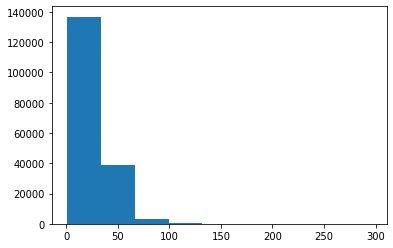

In [ ]:
plt.hist(sent_lens,bins=9)

In [ ]:
# Calculate the percentile of length of sentences
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len
# So 95% sentences are in length of 55

55

In [ ]:
# Creating a text Vectorization Layer
# Mapping our text from words to Numbers
# An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. 
# Vocabulary size in the Research Paper is 68000
max_tokens=68000
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)


In [ ]:
# Adapt the Text Vectorizer to the Training Data
# We have to adapt it to only the training data so that val and test data are not seen
# Later it can be fitted to the two latter
text_vectorizer.adapt(train_sentences)

In [ ]:
# Finding out how many words are there  in the training vocabulary and which are  most common
# Also text vectorizer works pretty straightforwardly, 1 to most common word, 2 to 2nd most common word and so on
train_vocab=text_vectorizer.get_vocabulary()
# Size of Vocab
print(len(train_vocab))
# 5 Most Common Words in the Vocab
print(train_vocab[:5])
# Least common 5 words in the vocab
print(train_vocab[-5:])

64841
['', '[UNK]', 'the', 'and', 'of']
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our Text Vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
# Create an Embedding Layer
# More output dims , more emmbedding, more parameters to train
# Masking the 0 considering themm as padding
token_embed=layers.Embedding(input_dim=len(train_vocab),output_dim=128,mask_zero=True,name="token_embedding")

In [ ]:
# Creating a Fast Loadinng Dataset with tf data API
# https://www.tensorflow.org/guide/data_performance
# https://www.tensorflow.org/guide/data
# Turn our data into Tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset
# <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>
# Which indicates one Text Sample in first tuple, next tuple is (0,0,0,0,1) -> 1hc 

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Pre fetching the data and making them into batches
# Pre fetching reduces the Preparation time of Data taken by CPU
# Pref-fetching in a Multi-threaded way Reduces time and Increases the amount of data as all cores can be utilized to Prepare the Data
# The GPU will do the Computation
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset
# Run the Previous steps as well this otherwie the Shapes will not be fixed
# PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#BERT 
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",
    trainable=False)
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5,activation="softmax")(net)
  return tf.keras.Model(text_input, net)

In [ ]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.52252656 0.50929254 0.628661   0.56633997 0.5198017 ]], shape=(1, 5), dtype=float32)


In [ ]:
train_labels_one_hot
train_sentences,train_labels_one_hot

(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
  'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
  'there was a

In [ ]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
# Compiling the Model
classifier_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
# history_model_1=classifier_model.fit(train_dataset,epochs=5,validation_data=val_dataset)
history = classifier_model.fit(x=train_dataset,
                               validation_data=val_dataset,
                               epochs=2)

Epoch 1/2
5627/5627 [==============================] - 2189s 388ms/step - loss: 0.8453 - accuracy: 0.6756 - val_loss: 0.7050 - val_accuracy: 0.7431
Epoch 2/2
5627/5627 [==============================] - 2173s 386ms/step - loss: 0.7327 - accuracy: 0.7224 - val_loss: 0.6563 - val_accuracy: 0.7639


In [ ]:
predictions = classifier_model.predict(test_dataset)

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

word_labels = np.unique(train_df["target"])
word_labels_short = [word_labels[i][:4] for i in np.arange(len(word_labels))]

Y_pred_classes = np.argmax(predictions,axis = 1) 

In [ ]:
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes, normalize='true') 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
ax.yaxis.set_ticklabels(word_labels_short)
ax.xaxis.set_ticklabels(word_labels_short)
plt.show()